## Word-level language model

In the previous tasks you have written character-level language model. Time has come to grow up.

Word language models face a lot of new problems for you to solve. There are some of them:
  * How to read long texts (Gbs of data)
  * How to build vocabulry (and to effectively reduce its size)
  * How to deal with out-of-vocabulary (OOV) words
  * How to construct batch of _uncorrelated_ examples (not from the same text)
  * How and when to drop RNN state
  * What special tokens should be used? BOS? EOS?

**Results of this task:**
  * Text preprocessing
  * Batcher
  * Trained language model:
    * model should use truncated backpropagation through time
    * model should drop RNN state between different documents (eg. wikipedia articles)
  * Test set perplexity

**Additional points:**
  * Text preprocessing and batching that works with large files (does not load all the file to memory)
  * AWD-LSTM or other uncommon RNN architectures (SRU, QRNN)
  * Use popular dataset 

It is becoming common to use [byte-pair encoding](https://github.com/google/sentencepiece) to solve vocabulary problem. Use it! Here is an [example](https://github.com/google/sentencepiece/blob/master/python/sentencepiece_python_module_example.ipynb).

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.nn import Module, Embedding, GRU, Linear, Dropout
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

from tqdm import tqdm
import re
from operator import itemgetter 

Data is news in russian language. Data was taken from https://github.com/maxoodf/russian_news_corpus.

In [2]:
with open('russian_news_orig.txt', 'r'):
    corpus = f.read().split('\n')

N articles: 1449368


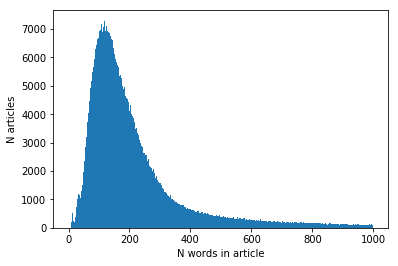

In [3]:
print('N articles:', len(corpus))

plt.hist([len(i.split(' ')) for i in corpus], range(0, 1000))
plt.xlabel('N words in article')
plt.ylabel('N articles')
plt.show()

In [4]:
short_corpus = corpus[:2000]

### Data processing

In [5]:
def process_corpus(corpus, min_sent_len=3):
    """
    input: list of articles
    output: list of sentences
    """
    proc_corpus = []
    with tqdm(total=len(corpus)) as pbar:
        for text in corpus:
            sentences = text.split('.')
            proc_sentences = [['<bos>'] + re.sub(r'[^\w\s]', '', sent).split(' ') + ['<eos>'] 
                              for sent in sentences]
            proc_corpus += [sent for sent in proc_sentences if len(sent) > min_sent_len]
            pbar.update(1)
        
    return proc_corpus

In [6]:
sentences = process_corpus(short_corpus)

100%|██████████| 2000/2000 [00:00<00:00, 9688.58it/s]


N sentences: 59752


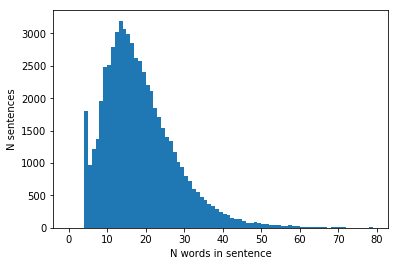

In [7]:
print('N sentences:', len(sentences))

plt.hist([len(i) for i in sentences], range(0, 80))
plt.xlabel('N words in sentence')
plt.ylabel('N sentences')
plt.show()

In [8]:
sentences[:2]

[['<bos>',
  'ru',
  'мид',
  'еще',
  'раз',
  'напомнил',
  'что',
  'россия',
  'асада',
  'не',
  'поддерживает',
  '<eos>'],
 ['<bos>',
  '',
  'российская',
  'военная',
  'операция',
  'в',
  'сирии',
  'не',
  'направлена',
  'на',
  'поддержку',
  'президента',
  'башара',
  'асада',
  'заявила',
  'официальный',
  'представитель',
  'мид',
  'рф',
  'мария',
  'захарова',
  '<eos>']]

In [9]:
class Vocabulary:
    def fit(self, sentences, max_vocab=50000):
        c = Counter([word for sent in sentences for word in sent])
        freq_sorted = sorted(c.items(), key=lambda item: item[1], reverse=True)
        self._vocab = ['<pad>', '<unk>'] + [word for word, _ in freq_sorted[:max_vocab - 2]]
        self._w2i = {w: i for i, w in enumerate(self._vocab)}
        del c, freq_sorted
        return self

    def __len__(self):
        return len(self._vocab)

    def transform(self, sent, remove_empty_srtings=True):
        proc_sent = []
        for word in sent:
            if remove_empty_srtings and word == '':
                continue
            proc_sent.append(self._w2i[word] if word in self._w2i else self._w2i['<unk>'])
        return proc_sent
        
    def w2i(self, word):
        return self._w2i[word] if word in self._w2i else self._w2i['<unk>']

In [10]:
voc = Vocabulary()
voc.fit(sentences)

In [11]:
class MyDataset(Dataset):
    
    def __init__(self, sentences, max_vocab=50000, vocab=None):
        self.sents = sentences
        if vocab:
            self.vocab = vocab
        else:
            self.vocab = Vocabulary()
            self.vocab.fit(self.sents, max_vocab=max_vocab)
        
    def __len__(self):
        return len(self.sents)
    
    def __getitem__(self, index):
        item = self.vocab.transform(self.sents[index])
        x = torch.LongTensor(item[:-1])
        y = torch.LongTensor(item[1:])
        return x, y

In [12]:
def pad_batch(batch, maxlen=50):
    lengths = [min(len(i[0]), maxlen) for i in batch]
    
    batch = [i[1] for i in sorted(zip(lengths, batch), key=lambda x: x[0], reverse=True)]
    lengths = torch.LongTensor(sorted(lengths, reverse=True))
    
    x = pad_sequence([i[0][:maxlen] for i in batch], batch_first=True)
    y = pad_sequence([i[1][:maxlen] for i in batch], batch_first=True)
    return (x, y), lengths

Check loder implementation

In [13]:
t = MyDataset(sentences)

In [14]:
loader = DataLoader(t, 10, collate_fn=pad_batch)

In [15]:
for (x, y), lengths in loader:
    print(x.shape, lengths)
    print(x)
    break

torch.Size([10, 29]) tensor([29, 23, 20, 19, 15, 14, 13, 13, 11,  5])
tensor([[    3,    30,  7478,  5917, 34629,   271,   147,  9341,     9,    41,
          7479,   172,    17,   387,  7479,   456, 34630, 21473,   706,     6,
          1626,     6, 10158,   299, 21474,  3956, 34631,  4834,    65],
        [    3,   110,    87,   172,   277,    96,     9,     7,   827,   702,
           241,     6,  5067,     5,   277,    23,   429,    75,  2658,   430,
             7,  3460,  1446,     0,     0,     0,     0,     0,     0],
        [    3,   486,  8036,  3054,     5,   277,     8,  6273,     7,   890,
           204,  5607,  2290,  1013,   936,   284,   465,    83,  1062,  1474,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    3, 11143, 34632,   669,    10, 34633,     6,  8614, 15715,     5,
            47,   160,     6,    10, 34634, 13784,   560,   152,    86,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
      

Split data and make datasets

In [16]:
l = len(sentences)
shuffled_indxs = np.random.permutation(l)
train_idxs = shuffled_indxs[:int(l * 0.7)]
val_idxs = shuffled_indxs[int(l * 0.7):int(l * 0.8)]
test_idxs = shuffled_indxs[int(l * 0.8):]

train_vocab = Vocabulary()
train_vocab.fit(itemgetter(*train_idxs)(sentences))

train_dataset = MyDataset(itemgetter(*train_idxs)(sentences), vocab=train_vocab)
val_dataset = MyDataset(itemgetter(*val_idxs)(sentences), vocab=train_vocab)
test_dataset = MyDataset(itemgetter(*test_idxs)(sentences), vocab=train_vocab)

print('train len', len(train_dataset))
print('val len', len(val_dataset))
print('test len', len(test_dataset))

train len 41826
val len 5975
test len 11951


### Model

In [17]:
class LanguageModel(Module):
    
    def __init__(self, vocab_size, emb_dim, hidden_dim, n_layers, dropout=0.5):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.emb = Embedding(vocab_size, emb_dim)
        self.gru = GRU(emb_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.fc = Linear(hidden_dim, vocab_size)
        
    def forward(self, x, lengths, h0):
        emb = self.emb(x)
#         print(emb.shape)
        gru_in = emb
#         print(gru_in.shape)
        gru_in = pack_padded_sequence(emb, lengths, batch_first=True)
        gru_out, gru_hidden = self.gru(gru_in, h0)
        gru_out, _ = pad_packed_sequence(gru_out, batch_first=True)
#         print(gru_out.shape)
        scores = self.fc(gru_out)
#         print(scores.shape)
        return scores, gru_hidden
    
    def init_hidden(self, batch_size, device=None):
        if device:
            return torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        else:
            return torch.zeros(self.n_layers, batch_size, self.hidden_dim)

Check model implementation

In [18]:
model = LanguageModel(len(t.vocab), 300, 100, 2)
model

LanguageModel(
  (emb): Embedding(50000, 300)
  (gru): GRU(300, 100, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=100, out_features=50000, bias=True)
)

In [19]:
cr = torch.nn.CrossEntropyLoss()
for (x, y), lengths in loader:
    h0 = model.init_hidden(loader.batch_size)
    pred, _ = model(x, lengths, h0)
#     print(pred.shape, y.shape)
    loss = cr(pred.permute(0,2,1), y)
#     acc = accuracy(pred, y)
    print(loss)
    break

tensor(10.8109, grad_fn=<NllLoss2DBackward>)


Make train, eval functions

In [20]:
def accuracy(pred, y):

    pred_lbl = F.softmax(pred, dim=2).argmax(dim=2)
    correct = (pred_lbl == y).float()
    acc = torch.mean(correct.sum(dim=1) / correct.shape[1])
    return acc

def perplexity(pred):
    
    pred_probs = torch.max(F.softmax(pred, dim=2), dim=2)[0]
    perplexity = torch.exp(-torch.mean(torch.log(pred_probs)))
    return perplexity

In [24]:
def save_model(model, optimizer, name):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'model_decription': str(model),
        'train_vocab': train_vocab
    }, name)

def train(model, loader, criterion, optimizer, device):
    model.to(device)
    model.train()
    
    epoch_loss, epoch_acc, epoch_perp = 0, 0, 0
    for (x, y), lengths in loader:
        h0 = model.init_hidden(x.shape[0])
        x, y, h0 = x.to(device), y.to(device), h0.to(device)

        model.zero_grad()
        out, h = model(x, lengths, h0)

        loss = criterion(out.permute(0,2,1), y)
        acc = accuracy(out, y)
        perp = perplexity(out)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_perp += perp.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader), epoch_perp / len(loader)

def evaluate(model, loader, criterion, device):
    model.to(device)
    model.eval()
    
    epoch_loss, epoch_acc, epoch_perp = 0, 0, 0
    
    with torch.no_grad():
        for (x, y), lengths in loader:
            h0 = model.init_hidden(x.shape[0])
            x, y, h0 = x.to(device), y.to(device), h0.to(device)
            
            out, _ = model(x, lengths, h0)

            loss = criterion(out.permute(0,2,1), y)
            acc = accuracy(out, y)
            perp = perplexity(out)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_perp += perp.item()
            
    return epoch_loss / len(loader), epoch_acc / len(loader), epoch_perp / len(loader)

Train model

In [26]:
EMB_DIM = 200
HIDDEN_DIM = 100
N_LAYERS = 1
DROPOUT = 0.5
BATCH_S = 80
EPOCHS = 150

train_loader = DataLoader(train_dataset, BATCH_S, collate_fn=pad_batch, num_workers=4)
val_loader = DataLoader(val_dataset, BATCH_S, collate_fn=pad_batch, num_workers=4)
voc_len = len(train_dataset.vocab)
device = torch.device('cuda:1')

model = LanguageModel(voc_len, EMB_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
optim = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

best_val_loss = np.inf
for epoch in range(EPOCHS):
    
    train_loss, train_acc, train_perp = train(model, train_loader, criterion, optim, device)
    val_loss, val_acc, val_perp = evaluate(model, val_loader, criterion, device)
    
    if val_loss < best_val_loss:
        save_model(model, optim, 'LM.pt')
        
    print('{} | TRAIN loss: {:.4f}, acc: {:.4f}, perp: {:.4f}; VAL loss: {:.4f}, acc: {:.4f}, perp: {:.4f}'.
             format(epoch + 1, train_loss, train_acc, train_perp, val_loss, val_acc, val_perp))
    

1 | TRAIN loss: 9.6540, acc: 0.4000, perp: 3878.3890; VAL loss: 9.0664, acc: 0.6880, perp: 1622.7436
2 | TRAIN loss: 8.9129, acc: 0.6844, perp: 1346.9217; VAL loss: 8.4764, acc: 0.6939, perp: 946.5124
3 | TRAIN loss: 8.2850, acc: 0.6898, perp: 798.6739; VAL loss: 7.9304, acc: 0.6970, perp: 564.0427
4 | TRAIN loss: 7.6777, acc: 0.6939, perp: 479.4010; VAL loss: 7.4097, acc: 0.6989, perp: 339.7322
5 | TRAIN loss: 7.0844, acc: 0.6973, perp: 289.6778; VAL loss: 6.9062, acc: 0.7000, perp: 206.6346
6 | TRAIN loss: 6.5026, acc: 0.7006, perp: 175.4918; VAL loss: 6.4154, acc: 0.7009, perp: 126.7327
7 | TRAIN loss: 5.9308, acc: 0.7041, perp: 106.5972; VAL loss: 5.9347, acc: 0.7011, perp: 78.4482
8 | TRAIN loss: 5.3692, acc: 0.7079, perp: 64.9932; VAL loss: 5.4621, acc: 0.7012, perp: 48.3533
9 | TRAIN loss: 4.8182, acc: 0.7118, perp: 39.7497; VAL loss: 4.9974, acc: 0.7012, perp: 29.9794
10 | TRAIN loss: 4.2784, acc: 0.7163, perp: 24.5145; VAL loss: 4.5479, acc: 0.7007, perp: 18.8682
11 | TRAIN lo

KeyboardInterrupt: 

In [ ]:
import gc
del model
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

In [ ]:
dump_tensors()

In [ ]:
torch.cuda.empty_cache()